In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy import sparse
from ppi import logistic, classical_logistic_interval, pp_logistic_interval
from ols_utils import transform_features
from tqdm import tqdm
import pdb

from logistic_utils import get_data, plot_data, get_tree, make_plots, acs_filter

/Users/angelopoulos/miniconda3/envs/mai/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Interval Constructions

Here we give constructions for the imputed, classical, and prediction-powered logistic regression intervals.

In [2]:
def trial(X, Y, Yhat, true, n, alpha):
    X_labeled, X_unlabeled, Y_labeled, Y_unlabeled, Yhat_labeled, Yhat_unlabeled = train_test_split(X, Y, Yhat, train_size=n)

    imputed_interval = classical_logistic_interval(X, Yhat, alpha)

    classical_interval = classical_logistic_interval(X_labeled, Y_labeled, alpha)

    pp_interval = pp_logistic_interval(X_labeled, X_unlabeled, Y_labeled, Yhat_labeled, Yhat_unlabeled, alpha)

    return imputed_interval, classical_interval, pp_interval

## Get census data relating income and private health insurance coverage in 2019

We load this data in from Folktables and then transform it if desired.

Then compute the true coefficients --- those we would have if we knew all of the census data.

In [3]:
# Year and whether to transform the data
curr_year = 2019
transform = False
# Feature codes to use
feature_names =['PINCP','AGEP', 'PUBCOV','SCHL','MAR','SCH','DIS','ESP','CIT','MIG','MIL','ANC','NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P']
ft = np.array(["q", "q", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c"])
regression_feature_name = "PINCP"
outcome_name = "PRIVCOV"
features, outcome = get_data(curr_year, feature_names, outcome_name, regression_feature_name, acs_filter=acs_filter)
reg_feat = features[regression_feature_name]
if transform:
    features, enc = transform_features(features, ft)
else:
    enc = None
    
# Collect logistic features
X = np.stack([reg_feat, np.ones_like(reg_feat)], axis=1)
X[:,1] = X[:,1] * (np.linalg.norm(X, axis=0)[0] / np.linalg.norm(X, axis=0)[1])
true = logistic(X, outcome.to_numpy())

print(f"True logistic regression coefficients: {true}")

True logistic regression coefficients: [1.91335746e-05 1.86659901e-07]


## Get the gradient boosting tree from the previous year

The tree is trained to predict income from the features list above. To get the meaning of the features, look at the PUMS Data Dictionary.

In [4]:
np.random.seed(0) # Fix seed for tree
tree = get_tree(curr_year-1, feature_names, ft, outcome_name, regression_feature_name, enc=enc, transform=transform, acs_filter=acs_filter)
np.random.seed(0) # Fix seed for evaluation
# Evaluate tree and plot data
predicted_outcome = tree.predict(xgb.DMatrix(features))

/Users/angelopoulos/miniconda3/envs/mai/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Perform logistic experiment

* Subsample `n` data points from 2019 with labels of private health insurance coverage.
* Impute the remaining `N-n` labels with the gradient boosting tree.
* Construct confidence intervals.

Repeat these steps `num_trials` times for each `n`, and plot the results!

In [5]:
try:
    df = pd.read_pickle('./.cache/logistic-results.pkl')
except:
    N = features.shape[0]
    ns = np.array([200, 300, 500, 1000, 2000, 5000, 10000])
    num_trials = 10
    alpha = 0.05

    # Store results
    columns = ["lb","ub","covered","estimator","n"]

    results = []
    for j in tqdm(range(ns.shape[0])):
        for i in range(num_trials):
            n = ns[j]
            ii, ci, ppi = trial(X, outcome.to_numpy(), predicted_outcome, true, n, alpha)
            temp_df = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)
            temp_df.loc[0] = ii[0][0], ii[1][0], (ii[0][0] <= true[0]) & (true[0] <= ii[1][0]), "imputed", n
            temp_df.loc[1] = ci[0][0], ci[1][0], (ci[0][0] <= true[0]) & (true[0] <= ci[1][0]), "classical", n
            temp_df.loc[2] = ppi[0][0], ppi[1][0], (ppi[0][0] <= true[0]) & (true[0] <= ppi[1][0]), "prediction-powered", n
            results += [temp_df]
    df = pd.concat(results)
    df["width"] = df["ub"] - df["lb"]
    df.to_pickle('./.cache/logistic-results.pkl')
ns = np.unique(df['n']).astype(int)
num_trials = len(df)//(3*ns.shape[0])

In [6]:
lower_endpoints = np.stack(
    [
        np.stack([df.lb[(df.estimator == "prediction-powered") & (df.n == n)] for n in ns], axis=0),
        np.stack([df.lb[(df.estimator == "classical") & (df.n == n)] for n in ns], axis=0),
        np.stack([df.lb[(df.estimator == "imputed") & (df.n == n)] for n in ns], axis=0)
    ],
    axis=2
)

upper_endpoints = np.stack(
    [
        np.stack([df.ub[(df.estimator == "prediction-powered") & (df.n == n)] for n in ns], axis=0),
        np.stack([df.ub[(df.estimator == "classical") & (df.n == n)] for n in ns], axis=0),
        np.stack([df.ub[(df.estimator == "imputed") & (df.n == n)] for n in ns], axis=0)
    ],
    axis=2
)

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

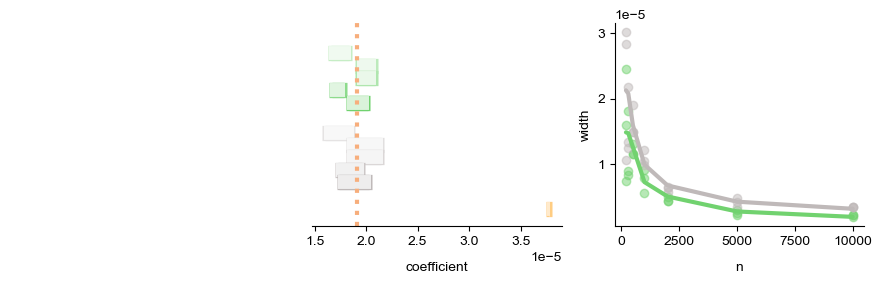

In [8]:
# Make plot
n_idx = 6
num_intervals = 5

pp_intervals = []
classical_intervals = []
for i in range(num_intervals):
    trial_idx = np.random.choice(num_trials)
    
    pp_intervals += [
        [lower_endpoints[n_idx,trial_idx,0], upper_endpoints[n_idx,trial_idx,0]]
    ]
    
    classical_intervals += [
        [lower_endpoints[n_idx,trial_idx,1], upper_endpoints[n_idx,trial_idx,1]]
    ]
    
imputed_interval = [lower_endpoints[n_idx,0,2], upper_endpoints[n_idx,0,2]]

xlim = [None, None]
ylim = [0,1.15]
linewidth = 10
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
sns.set_theme(style="white", font_scale=1, font="DejaVu Sans")

for i in reversed(range(num_intervals)):
    pp_interval = pp_intervals[i]
    classical_interval = classical_intervals[i]
    
    if i == 0:
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7, 0.7], linewidth=linewidth, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=linewidth * 1.1, offset=(-1,0), foreground="#71D26F"), pe.Stroke(linewidth=linewidth * 1.1, offset=(1,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered', solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25,0.25], linewidth=linewidth, color="#EEEDED", path_effects=[pe.Stroke(linewidth=linewidth * 1.1, offset=(-1,0), foreground="#BFB9B9"), pe.Stroke(linewidth=linewidth * 1.1, offset=(1,0), foreground="#BFB9B9"), pe.Normal()], label=' classical', solid_capstyle="butt")
        axs[1].plot([imputed_interval[0], imputed_interval[1]],[0.1, 0.1], linewidth=linewidth, color="#FFEACC", path_effects=[pe.Stroke(linewidth=linewidth * 1.1, offset=(-1,0), foreground="#FFCD82"), pe.Stroke(linewidth=linewidth * 1.1, offset=(1,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
    else:
        lighten_factor = 0.8/np.sqrt(i)
        yshift = i*0.07
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7 + yshift, 0.7 + yshift], linewidth=linewidth, color=lighten_color("#DAF3DA", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * 1.1, offset=(-1,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Stroke(linewidth=linewidth * 1.1, offset=(1,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Normal()], solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25 + yshift,0.25 + yshift], linewidth=linewidth, color=lighten_color("#EEEDED", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * 1.1, offset=(-1,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Stroke(linewidth=linewidth * 1.1, offset=(1,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Normal()], solid_capstyle="butt")


axs[1].set_xlabel("coefficient", labelpad=10)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_ylim(ylim)
axs[1].set_xlim(xlim)

axs[1].axvline(true[0], ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="true deforestation fraction", color="#F7AE7C")

sns.despine(ax=axs[1],top=True,right=True,left=True)

axs[2].plot(ns, upper_endpoints.mean(axis=1)[:,0]-lower_endpoints.mean(axis=1)[:,0], label="prediction-powered", color="#71D26F", linewidth=3)
num_scatter = 3
rand_idx_scatter = [np.random.choice(num_trials, size=num_scatter).astype(int) for n in ns]

scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_trials])[rand_idx_scatter[j]] for j in range(ns.shape[0])])
scatter_ys = np.concatenate([upper_endpoints[j,:,0][rand_idx_scatter[j]].flatten() - lower_endpoints[j,:,0][rand_idx_scatter[j]].flatten() for j in range(ns.shape[0])])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#71D26F",
    alpha=0.5
)
    
axs[2].plot(ns, upper_endpoints.mean(axis=1)[:,1]-lower_endpoints.mean(axis=1)[:,1], label="classical", color="#BFB9B9", linewidth=3)
scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_trials])[rand_idx_scatter[j]] for j in range(ns.shape[0])])
scatter_ys = np.concatenate([upper_endpoints[j,:,1][rand_idx_scatter[j]].flatten() - lower_endpoints[j,:,1][rand_idx_scatter[j]].flatten() for j in range(ns.shape[0])])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#BFB9B9",
    alpha=0.5
)

axs[2].locator_params(axis='y', tight=None, nbins=6)
axs[2].set_ylabel("width")
axs[2].set_xlabel("n",  labelpad=10)
sns.despine(ax=axs[2],top=True, right=True)

sns.despine(ax=axs[0],top=True, right=True, left=True, bottom=True)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_xticks([])
axs[0].set_yticks([])

plt.tight_layout()
plt.savefig('./logistic-plots/allplots.pdf')